In [148]:
import pymssql
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

### Connect to the Database


In [112]:
conn = pymssql.connect(server='localhost', user='sa', password='Passw0rd!', database='Loans_2023_01_27')
cursor = conn.cursor()

In [113]:
def get_column_index(cursor, column_name):
    for index, col in enumerate(cursor.description):
        if col[0] == column_name:
            return index

### Constructs a DataFrame with the entities from UnderwritingData and the Result from RawAlgorithmData

In [114]:
additional_data_headers = ["RentMortgagePayment" ,"TotalIncome" ,"RentMortgage" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles"]
additional_data_sql = "VIN,"
for i, header in enumerate(additional_data_headers):
    additional_data_sql += header
    if i!=len(additional_data_headers)-1:
        additional_data_sql+=','

In [137]:
headers = []
rows = []

# Underwriting Data
cursor.execute("SELECT * FROM dbo.UnderwritingData")

for entity in cursor.description:
    headers.append(entity[0])

vin_index = get_column_index(cursor, "VIN")

res = cursor.fetchone()
while res:
    row = [element for element in res]
    if row[vin_index] is not None:
        row[vin_index] = row[vin_index][-6:]
        rows.append(row)
    res = cursor.fetchone()

df = pd.DataFrame(rows, columns=headers)


#Additional Data
cursor.execute("Select {vCols} FROM dbo.VerificationsDec".format(vCols = additional_data_sql))

addl_data_rows = []
res = cursor.fetchone()

while res:
    row = [element for element in res]
    row[0] = row[0].strip()[-6:]
    addl_data_rows.append(row)
    res = cursor.fetchone()

print("Assigning Additional Entities")
for data in tqdm(addl_data_rows):
    df.loc[df['VIN']==data[0], additional_data_headers] = data[1:]

#Results from RawAlgorithmData
cursor.execute("SELECT Vin6,ProcStatsCd FROM dbo.RawAlgorithmData")
res = cursor.fetchone()
loan_results = dict()
while res:
    vin6 = res[0].strip()[-6:]
    loan_results[vin6] = res[1].strip()
    res = cursor.fetchone()

default_result = ["NA" for i in range(len(df))]
df['Result'] = default_result

print("Assigning Results")
for vin6, res in tqdm(loan_results.items()):
    df.loc[df['VIN'] == vin6, 'Result'] = res

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Foreclosure","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "Result"]]

Assigning Additional Entities


100%|██████████| 28023/28023 [00:32<00:00, 860.65it/s]


Assigning Results


100%|██████████| 24961/24961 [00:17<00:00, 1411.81it/s]


### Prune the DataFrame to only include CL and CO
#### And change CO to 0 and CL to 1

In [138]:
df = df[(df['Result']=='CO') | (df['Result']=='CL')]
df['Result'].replace(to_replace=['CO', 'CL'], value=[0,1], inplace=True)

In [139]:
label_encoder = LabelEncoder()
# df = label_encoder.fit_transform(df)

for column in df.columns:
    print(column)
    df[column] = label_encoder.fit_transform(df[column])


x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2, random_state=42)

logReg = LogisticRegression(max_iter=10000)#, class_weight='balanced')
rfe = RFE(estimator = logReg, n_features_to_select = 25)
rfe.fit(x_train, y_train.values.ravel())

train_pred = rfe.predict(x_train)
test_pred = rfe.predict(x_test)


train_confusion = metrics.confusion_matrix(y_train, train_pred)
test_confusion = metrics.confusion_matrix(y_test, test_pred)
print("Training Confusion Matrix: ")
print(train_confusion)
print("Test Confusion Matrix: ")
print(test_confusion)
print("Test Accuracy: ")
metrics.accuracy_score(y_test, test_pred)

RentMortgagePayment
TotalIncome
CarPayment
Expenses
AvailableIncome
Miles
OpeningBalance
Salary
Term
VehicleYear
CreaditScore
LTV
DTI
TradelinesTotal
TradelinesBalance
Foreclosure
Reposessions
Bankrupcies
Chageoff
Mortgage
NinetyDaysDelinquent
InquiresTotal
OpenTotal
ClosedTotalTermsNotPaid
LatePaymentHistory001230
LatePaymentHistory001260
LatePaymentHistory001290Plus
PaidAccounts
InquiriesLast6Months
OpenTotalInBadStatus
CurrentPaymentsMade
RentMortgage
CashDown
HomeOwner
Result
Training Confusion Matrix: 
[[2145 1826]
 [1577 2698]]
Test Confusion Matrix: 
[[556 463]
 [395 648]]
Test Accuracy: 


0.5838991270611057

In [121]:
print("Training Data ROC and AUC")
train_proba = rfe.predict_proba(x_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train, train_proba, pos_label="M")
auc = metrics.roc_auc_score(y_train, train_proba)
plt.plot(fpr,tpr,label="Train Data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Training Data ROC and AUC


/Users/nikhil/Documents/401/CODE/Scorelate/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:769: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_true = y_true == pos_label


TypeError: 'bool' object is not subscriptable

In [119]:
print(rfe.get_feature_names_out())

# for i in range(0, len(rfe.support_)):
#     if(rfe.support_[i]):
#         print(rfe.feature_names_in_[i])

['Bankrupcies' 'Chageoff' 'Mortgage' 'OpenTotal' 'PaidAccounts'
 'OpenTotalInBadStatus' 'HomeOwner']


### XGBoost

In [140]:
xgdata = df.copy(deep=True)
# xgdata = xgdata[['CreaditScore', 'InquiresTotal', 'Expenses', 'CashDown', 'OpeningBalance', 'Result']]

In [141]:
for x in tqdm(range(100)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train)
    test = xgb.DMatrix(x_test, label=y_test)

    param = {
        'eta': 0.01,
        'objective': 'multi:softprob',
        'num_class': 2
    }
    epochs = 500

    model = xgb.train(param, train, epochs)
    predictions = model.predict(test)
    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(accuracy_score(y_test, y), 3) * 100
    # print(acc)
    model.save_model('Models/XGBoost_{}%_Scorelate.json'.format(acc))

 13%|█▎        | 13/100 [02:48<18:47, 12.96s/it]


KeyboardInterrupt: 

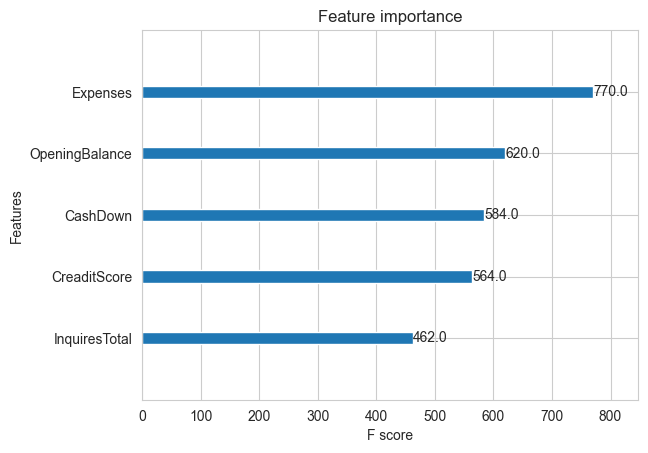

In [67]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('Models/XGBoost_61.3%_Scorelate.json')


# plot feature importance
plot_importance(xgb_ml)
plt.show()